# Imports and Initialization

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import pandas as pd
pd.set_option("max_columns", None)
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv("data/archive/cumulative.csv")
# WRITE THIS
# majority of the features are numeric and don't require any further preprocessing 1:35 to 2:45
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [3]:
print(df.koi_tce_delivname.value_counts())

q1_q17_dr25_tce    8054
q1_q16_tce          796
q1_q17_dr24_tce     368
Name: koi_tce_delivname, dtype: int64


# Preprocessing

In [4]:
def preprocess(df):
    df_pp = df.copy()
    
    # in order to make this a binary classification problem and to deal with imbalance, I will be removing false positives and only using confirmed and candidate
    false_positives = df_pp.query("koi_disposition == 'FALSE POSITIVE'")
    df_pp = df_pp.drop(false_positives.index).reset_index(drop=True)
    
    # drop unecessary columns, everything else is valid measurments taken from the objects
    # there are also two columns which contain no values in any rows, koi_teq_err1 and koi_teq_err2, not sure why, all others columns maintain sufficient enough entries, the lowest being 4456/4541, from what ive read tpyically you want nothing more than 20%
    # all numeric except koi_tce_delivname, but only a few unique values so it can be taken as a categorical variable, there are only 3 unique values so we will simply one hot encode
    df_pp = df_pp.drop(['kepid', 'rowid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score', 'koi_teq_err1', 'koi_teq_err2'], axis = 1)
    
    # fill missing categorical values with mode of the column
    delivname_col = df_pp['koi_tce_delivname']
    df_pp['koi_tce_delivname'] = delivname_col.fillna(delivname_col.mode()[0])
    # fill missing numeric values with mean of the column, returns a set of the columns that are missing values in certain rows df_pp.columns[df_pp.isna().sum() > 0]
    for column in df_pp.columns[df_pp.isna().sum() > 0]:
        df_pp[column] = df_pp[column].fillna(df_pp[column].mean())
        
    # one hot encode koi_tce_delivname
    delivname_dummies = pd.get_dummies(df_pp['koi_tce_delivname'], prefix = "koi_tce_delivname")
    df_pp = df_pp.drop('koi_tce_delivname', axis = 1)
    df_pp = pd.concat([df_pp, delivname_dummies], axis = 1)
    
    return df_pp

In [5]:
df_pp = preprocess(df)
df_pp.info()
df_pp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4541 entries, 0 to 4540
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   koi_disposition                    4541 non-null   object 
 1   koi_fpflag_nt                      4541 non-null   int64  
 2   koi_fpflag_ss                      4541 non-null   int64  
 3   koi_fpflag_co                      4541 non-null   int64  
 4   koi_fpflag_ec                      4541 non-null   int64  
 5   koi_period                         4541 non-null   float64
 6   koi_period_err1                    4541 non-null   float64
 7   koi_period_err2                    4541 non-null   float64
 8   koi_time0bk                        4541 non-null   float64
 9   koi_time0bk_err1                   4541 non-null   float64
 10  koi_time0bk_err2                   4541 non-null   float64
 11  koi_impact                         4541 non-null   float

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce,koi_tce_delivname_q1_q17_dr25_tce
0,CONFIRMED,0,0,0,0,9.488036,0.000028,-0.000028,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.9575,0.0819,-0.0819,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0,0,1
1,CONFIRMED,0,0,0,0,54.418383,0.000248,-0.000248,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.5070,0.1160,-0.1160,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0,0,1
2,CONFIRMED,0,0,0,0,2.525592,0.000004,-0.000004,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.6545,0.0420,-0.0420,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,0,0,1
3,CONFIRMED,0,0,0,0,11.094321,0.000020,-0.000020,171.201160,0.001410,-0.001410,0.538,0.030,-0.428,4.5945,0.0610,-0.0610,1517.5,24.2,-24.2,3.90,1.27,-0.42,835.0,114.81,112.85,-36.70,66.5,1.0,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,0,0,1
4,CONFIRMED,0,0,0,0,4.134435,0.000010,-0.000010,172.979370,0.001900,-0.001900,0.762,0.139,-0.532,3.1402,0.0673,-0.0673,686.0,18.7,-18.7,2.77,0.90,-0.30,1160.0,427.65,420.33,-136.70,40.2,2.0,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4536,CANDIDATE,0,0,0,0,4.736816,0.000147,-0.000147,131.787600,0.025600,-0.025600,0.218,0.285,-0.218,2.8400,1.0000,-1.0000,35.3,12.6,-12.6,0.60,0.20,-0.06,1137.0,395.05,377.30,-120.72,6.9,1.0,6088.0,165.0,-201.0,4.456,0.056,-0.224,1.011,0.329,-0.110,289.20331,44.505138,13.922,0,0,1
4537,CANDIDATE,0,0,0,0,130.235324,0.003030,-0.003030,218.271900,0.020100,-0.020100,0.075,0.387,-0.075,5.6780,0.5340,-0.5340,750.1,91.4,-91.4,2.44,0.68,-0.23,332.0,2.86,2.38,-0.80,9.7,1.0,5616.0,166.0,-183.0,4.529,0.036,-0.192,0.903,0.251,-0.084,289.57452,44.519939,15.991,0,0,1
4538,CANDIDATE,0,0,0,0,8.870416,0.000009,-0.000009,137.481093,0.000869,-0.000869,1.206,70.610,-0.033,1.2864,0.0514,-0.0514,873.1,25.8,-25.8,39.46,11.10,-16.68,1151.0,414.26,360.89,-292.07,43.8,1.0,6022.0,200.0,-181.0,4.027,0.434,-0.186,1.514,0.426,-0.640,290.14914,50.239178,13.579,0,0,1
4539,CANDIDATE,0,0,0,0,47.109631,0.000194,-0.000194,144.131720,0.003430,-0.003430,1.230,6.923,-0.605,5.7410,0.1720,-0.1720,752.2,22.2,-22.2,78.98,30.94,-57.45,751.0,75.40,89.11,-70.44,35.1,1.0,5258.0,159.0,-159.0,3.597,0.968,-0.242,2.780,1.089,-2.022,296.15601,44.920090,13.731,0,0,1


In [6]:
print(df['koi_disposition'].value_counts(), "\n")
print(df_pp['koi_disposition'].value_counts())

FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64 

CONFIRMED    2293
CANDIDATE    2248
Name: koi_disposition, dtype: int64


In [7]:
# split the data into features and labels
X = df_pp.drop('koi_disposition', axis = 1)
y = df_pp['koi_disposition']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, shuffle = True, random_state = 11)

In [8]:
# scale data to make sure every column has the same range of values, tree based models don't necessarily require this but logistic regression and neural networks perform better with this done and the tree based models shouldnt be effected because of it
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index = X_train.index, columns = X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index = X_test.index, columns = X_test.columns)
print(y_train.value_counts())
X_train

CONFIRMED    1602
CANDIDATE    1576
Name: koi_disposition, dtype: int64


,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce,koi_tce_delivname_q1_q17_dr25_tce
4382,-0.056183,-0.112902,-0.039696,-0.017742,-0.039368,0.004287,-0.004287,-0.511860,0.005165,-0.005165,0.005123,0.008330,0.002759,-0.259077,0.007006,-0.007006,-0.012654,0.032779,-0.032779,0.022917,0.021770,-0.072422,0.011451,0.175054,0.071588,-0.282840,-0.009911,3.352783,-0.006344,0.003391,-0.004060,-0.012914,0.006124,-0.003727,0.108707,0.047158,-0.083269,-1.087800,0.385627,0.821118,-0.23025,-0.184847,0.301615
3786,-0.056183,-0.112902,-0.039696,-0.017742,-0.026884,-0.121132,0.121132,-0.302438,0.216970,-0.216970,-0.127879,-0.120312,0.013707,-0.038972,0.318135,-0.318135,-0.138514,-0.189561,0.189561,-0.048026,-0.038887,0.076109,-0.714598,-0.088640,-0.079197,0.090619,-0.208088,-0.488808,-0.647565,-0.976337,1.049444,0.314748,-0.109164,1.148400,-0.306621,-0.751502,0.360607,-1.823917,0.778073,0.123290,-0.23025,-0.184847,0.301615
1997,-0.056183,-0.112902,-0.039696,-0.017742,-0.029851,-0.210392,0.210392,0.120917,-0.357437,0.357437,-0.128712,-0.127272,0.014616,-0.777283,-0.444934,0.444934,-0.099398,-0.369978,0.369978,-0.047586,-0.038451,0.074656,-1.044017,-0.089756,-0.079442,0.091143,-0.045033,0.791722,-2.488798,-1.132467,0.914787,1.211394,-0.475596,1.221247,-0.645830,-0.798059,0.436119,-0.186240,-0.232930,-1.108541,-0.23025,-0.184847,0.301615
1632,-0.056183,-0.112902,-0.039696,-0.017742,-0.037428,-0.212683,0.212683,-0.486871,-0.313546,0.313546,0.271267,-0.123792,-0.226952,-0.959281,-0.369782,0.369782,-0.135552,-0.318430,0.318430,-0.047498,-0.038669,0.079016,-0.162870,-0.082020,-0.077467,0.088224,-0.176047,-0.488808,-1.036415,-0.686383,0.695969,0.686120,-0.658811,1.148400,-0.427167,-0.778660,0.466883,1.683916,0.408222,-0.487900,-0.23025,-0.184847,0.301615
2264,-0.056183,-0.112902,-0.039696,-0.017742,-0.037320,-0.213905,0.213905,0.123761,-0.364962,0.364962,-0.132045,-0.133238,0.018248,0.004860,-0.442194,0.442194,-0.046320,-0.434413,0.434413,-0.028035,-0.015570,0.055761,0.407046,-0.062167,-0.043076,0.071750,0.293181,-0.488808,0.709058,1.187171,-1.020908,0.247834,-0.302023,-1.037032,-0.169256,0.369739,0.259925,1.061356,1.144731,0.079971,-0.23025,-0.184847,0.301615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,-0.056183,-0.112902,-0.039696,-0.017742,-0.035392,-0.198024,0.198024,-0.341106,-0.071425,0.071425,-0.392031,-0.068939,0.301590,0.082558,-0.098725,0.098725,-0.131011,-0.251848,0.251848,-0.039131,-0.032132,0.055761,0.324186,-0.066188,-0.064365,0.071465,-0.190999,2.072253,0.864307,-0.106473,0.258333,-0.508294,0.459769,0.201379,0.126968,-0.049271,-0.058903,0.249754,-1.565308,0.777011,-0.23025,-0.184847,0.301615
1293,-0.056183,-0.112902,-0.039696,-0.017742,-0.036054,-0.209444,0.209444,-0.511247,-0.256989,0.256989,0.368762,-0.139701,-0.324124,-0.635956,-0.355103,0.355103,-0.134128,-0.350648,0.350648,-0.043094,-0.028645,0.067388,-0.168933,-0.082117,-0.069864,0.085689,-0.169994,-0.488808,-0.602586,0.584958,0.005852,0.231105,-0.012735,-2.129748,-0.270177,0.152475,0.259925,1.204550,-1.169635,-0.487112,-0.23025,-0.184847,0.301615
4023,-0.056183,-0.112902,-0.039696,-0.017742,0.177762,8.479076,-8.479076,-0.011397,3.133641,-3.133641,0.421426,-0.139784,-0.332570,1.299212,2.627499,-2.627499,-0.113960,1.208676,-1.208676,-0.039307,-0.023633,0.075382,-1.298661,-0.090005,-0.079468,0.091290,-0.224109,-0.488808

# Training and Results

In [9]:
models = {
    "Logistic Regression": LogisticRegression(),
    "      Decision Tree": DecisionTreeClassifier(),
    "     Neural Network": MLPClassifier(),
    "      Random Forest": RandomForestClassifier(),
    "  Gradient Boosting": GradientBoostingClassifier(),
    "  RidgeClassifierCV": RidgeClassifier(),
    " AdaBoostClassifier": AdaBoostClassifier(),
   "ExtraTreesClassifier": ExtraTreesClassifier(),
    "          LinearSVC": LinearSVC(),
    "              NuSVC": NuSVC(),
    "KNeighborsClassifier": KNeighborsClassifier(10),
    "ExtraTreeClassifier ": ExtraTreeClassifier()
    # add auc roc
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained")

Logistic Regression trained
      Decision Tree trained
     Neural Network trained
      Random Forest trained
  Gradient Boosting trained
  RidgeClassifierCV trained
 AdaBoostClassifier trained
ExtraTreesClassifier trained
          LinearSVC trained
              NuSVC trained
KNeighborsClassifier trained
ExtraTreeClassifier  trained


In [10]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) 
    # model.evaluate ?
    print(name + " Accuracy: ", accuracy * 100)

Logistic Regression Accuracy:  81.73147468818782
      Decision Tree Accuracy:  74.39471753484959
     Neural Network Accuracy:  81.51137197358767
      Random Forest Accuracy:  81.14453411592076
  Gradient Boosting Accuracy:  82.31841526045488
  RidgeClassifierCV Accuracy:  70.2127659574468
 AdaBoostClassifier Accuracy:  82.83198826118856
ExtraTreesClassifier Accuracy:  81.58473954512105
          LinearSVC Accuracy:  80.70432868672047
              NuSVC Accuracy:  80.92443140132062
KNeighborsClassifier Accuracy:  74.02787967718268
ExtraTreeClassifier  Accuracy:  71.23991195891416


In [11]:
# In a basic sense, Accuracy is a good measure of overall, out of all the training examples, how many did the model get right
# however, it doesn't take it account the balance between the classes,so if you're doing really well in one class and not so good in another, accuracy won't provide any information on that
# We can use the f1 score for this however, it's not comepltely necessary because we have a pretty balanced dataset, but generally it is a more informative metric for evaluating the performance of a classification model
# confirmed is technically the positive label
# describe how f1 uses precision and recall
for name, model in models.items():
    y_pred = model.predict(X_test)
    f_score = f1_score(y_test, y_pred, pos_label = "CONFIRMED")
    print(name + " F1 Score: ", f_score)

Logistic Regression F1 Score:  0.8314150304671633
      Decision Tree F1 Score:  0.7397464578672633
     Neural Network F1 Score:  0.8181818181818182
      Random Forest F1 Score:  0.8162973552537527
  Gradient Boosting F1 Score:  0.8322894919972165
  RidgeClassifierCV F1 Score:  0.7339449541284404
 AdaBoostClassifier F1 Score:  0.8359046283309958
ExtraTreesClassifier F1 Score:  0.8228652081863091
          LinearSVC F1 Score:  0.8245496997998667
              NuSVC F1 Score:  0.8204419889502763
KNeighborsClassifier F1 Score:  0.7541666666666667
ExtraTreeClassifier  F1 Score:  0.7138686131386861


     Logistic Regression Conf Matrix: 
           Decision Tree Conf Matrix: 
          Neural Network Conf Matrix: 
           Random Forest Conf Matrix: 
       Gradient Boosting Conf Matrix: 
       RidgeClassifierCV Conf Matrix: 
      AdaBoostClassifier Conf Matrix: 
     ExtraTreesClassifier Conf Matrix: 
               LinearSVC Conf Matrix: 
                   NuSVC Conf Matrix: 
     KNeighborsClassifier Conf Matrix: 
     ExtraTreeClassifier  Conf Matrix: 


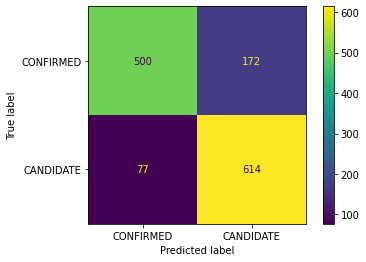

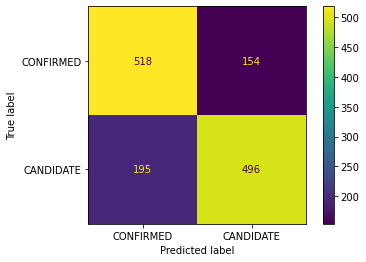

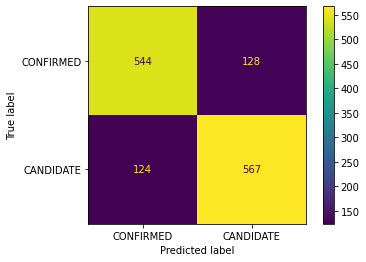

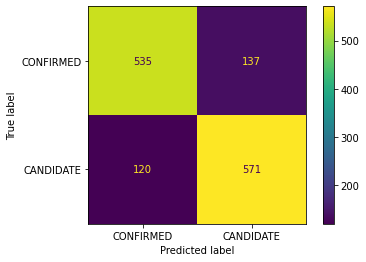

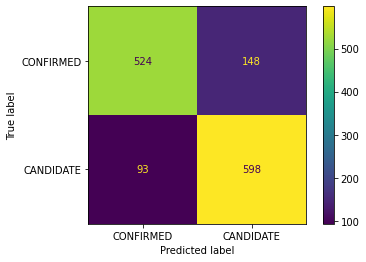

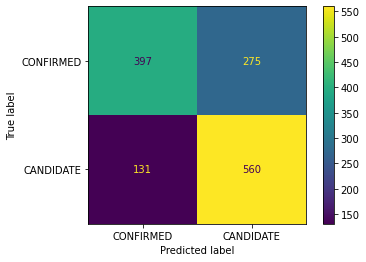

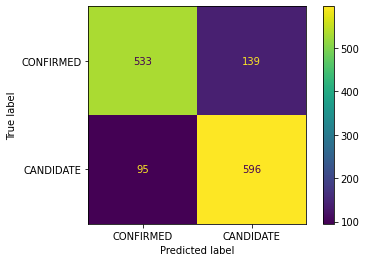

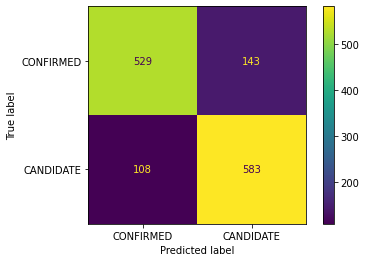

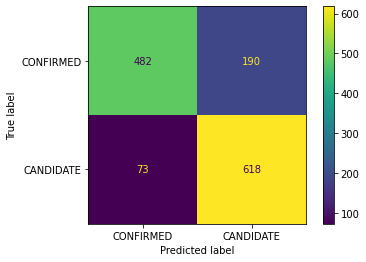

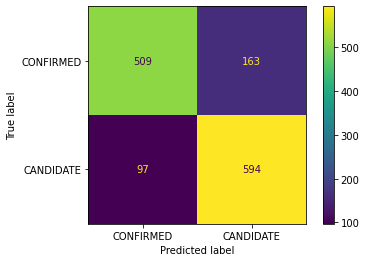

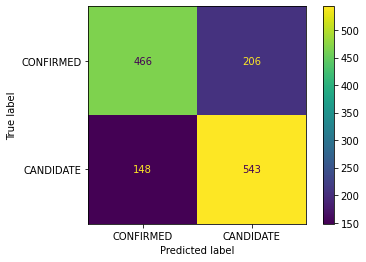

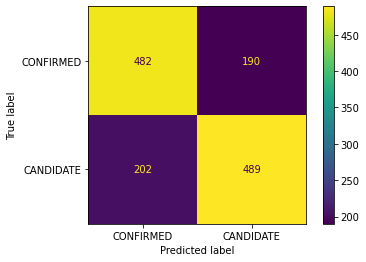

In [19]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = y_test.array.unique())
    print("     " + name + " Conf Matrix: ")
    disp.plot()